# Notebook for fitting SSM using `dynamax`

In [114]:
import jax
import jax.numpy as jnp
from dynamax.linear_gaussian_ssm.models import LinearGaussianSSM
from dynamax.utils.utils import monotonically_increasing, random_rotation

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter
from scipy.ndimage import gaussian_filter1d
from matplotlib import colormaps

# Get data

In [5]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [6]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [7]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Get single-reach trials

In [8]:
control_idxs = np.where(data["pattern_id"] == 0)[0]
control_idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  27,  33,  39,  45,  51,  57,  63,  69,  75,
        81,  87,  93,  99, 105, 111, 117, 123, 129, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449])

In [9]:
stim_idxs = np.where(data["pattern_id"][:150] > 2)[0]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
control_idxs = np.sort(np.concatenate((control_idxs, stim_idxs)))

In [10]:
# get no laser trials
control_idxs = np.intersect1d(control_idxs, np.where(data["single"] == 1)[1])

In [11]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        17,  19,  20,  21,  23,  24,  30,  33,  36,  39,  40,  43,  44,
        45,  46,  49,  50,  51,  53,  54,  60,  61,  62,  63,  67,  69,
        70,  71,  74,  77,  81,  82,  88,  89,  91, 105, 107, 116, 117,
       137, 139, 145, 148])

In [12]:
np.unique(data["pattern_id"][control_idxs])

array([ 0, 14, 17, 20], dtype=uint8)

## Get relevant time information

In [13]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

array([[  14310.86566601,   31635.98602851,   66118.75767016,
          83391.57934485,  100671.38676484,  117878.88228075,
         135202.39780987,  152469.08335693,  169748.98517889,
         187076.46559048,  221580.66647786,  256113.84876805,
         343834.9853677 ,  378401.3027471 ,  412964.5048617 ,
         430223.16624186,  447413.10299254,  481960.06796941,
         499231.75682054,  603021.71245162,  654737.65694326,
         706335.69338242,  758001.60483338,  775155.48003398,
         826860.47389786,  844093.36354196,  861313.50892099,
         878540.9232512 ,  930339.75266686,  947557.06598697,
         964758.89738507,  999343.5287454 , 1016540.9232512 ,
        1120486.35891627, 1137781.83706221, 1155099.87727745,
        1172344.18955914, 1241575.09676201, 1276101.01010101,
        1293329.17964694, 1310604.83338053, 1362412.63098272,
        1414270.55602757, 1483298.49900878, 1500421.5047673 ,
        1604049.56103087, 1621268.29038044, 1655724.06306051,
        

In [14]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

array([[310., 280., 330., 320., 300., 250., 270.,  90., 260., 260., 230.,
        230., 310., 290., 200., 280., 220., 270., 270., 300., 230., 290.,
        290., 310., 270., 320., 280., 290., 250., 270., 250., 280., 270.,
        290., 270., 270., 270., 260., 300., 320., 310., 310., 280., 280.,
        340., 270., 300., 310., 300., 300., 290., 200., 290., 340., 250.,
        220.]])

In [15]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

array([[540., 540., 560., 570., 520., 540., 600., 460., 510., 490., 500.,
        530., 510., 520., 510., 630., 510., 480., 520., 570., 490., 670.,
        590., 570., 510., 640., 520., 560., 480., 520., 530., 490., 590.,
        520., 550., 570., 620., 520., 510., 550., 580., 650., 510., 520.,
        570., 480., 570., 550., 570., 530., 500., 560., 530., 570., 590.,
        480.]])

In [16]:
p_ids = np.unique(data["pattern_id"][control_idxs])
p_ids

array([ 0, 14, 17, 20], dtype=uint8)

## Get the AP.bin file

In [17]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [18]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [19]:
meta_data = get_meta(meta_path)

In [20]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [21]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [22]:
vmax

0.6

In [23]:
imax

512.0

In [24]:
gain

500.0

# Get trials

In [81]:
all_data = list()

# HYPERPARAMETERS TO TOGGLE
bin_size = 5
Q=1e-2

p_colors = list()
c = {0: "indigo", 14: "teal", 17: "magenta", 20: "orange"}

for i in tqdm(control_idxs):
    trial_no = i
    p_colors.append(c[data["pattern_id"][i][0]])
    # get time points in ap space
    lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
    
    # get end of behavior = mouth (260ms) + 300ms 
    end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)
    #print(lift_time, end_behavior)

    trial = ap_data[:150, lift_time:end_behavior]

    conv_data = 1e6 * trial / vmax / imax / gain

    filt_data = butter_filter(conv_data, 1_000, 30_000)

    c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
    m_start = c_start - (30 * 2000)
    trial_median = ap_data[:150, m_start:c_start]

    trial_median = 1e6 * trial_median / vmax / imax / gain
    trial_median = butter_filter(trial_median, 1_000, 30_000)
    
    median = np.median(trial_median, axis=1)

    spike_ixs, counts = get_spike_events(filt_data, median)
    
    a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

    for i, sc in enumerate(spike_ixs):
        a[i, sc] = 1

    b = bin_size * 30 # 30ms per bin
    binned_spikes = bin_spikes(a, b)

    if bin_size <= 20:
        sigma = 4
    else:
        sigma = 3

    smoothed = gaussian_filter1d(binned_spikes, sigma=sigma, axis=1)

    #smoothed = kalman_filter(binned_spikes, Q=Q)

    all_data.append(smoothed)

  0%|                                          | 0/56 [00:00<?, ?it/s]/tmp/ipykernel_14610/1178139095.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
/tmp/ipykernel_14610/1178139095.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)
/tmp/ipykernel_14610/1178139095.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

## Concatenate trials together

In [85]:
model_data = list()

lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

for d in all_data:
    model_data.append(d[:, lift_start:after_lift].T)

d = np.concatenate(model_data, axis=1)

In [86]:
d = np.array(model_data)

In [87]:
d.shape

(56, 60, 150)

# Initialize the model

In [181]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax import vmap
from jax.nn import softplus
from tensorflow_probability.substrates.jax.distributions import Poisson

from dynamax.generalized_gaussian_ssm import ParamsGGSSM, GeneralizedGaussianSSM, EKFIntegrals
from dynamax.generalized_gaussian_ssm import conditional_moments_gaussian_smoother as cmgs
from dynamax.utils.utils import random_rotation

In [182]:
state_dim = 3
emission_dim = d.shape[-1]
num_timesteps = d.shape[1]
num_trials = d.shape[0]

# Sample random parameters
dynamics_matrix = random_rotation(jr.PRNGKey(0), state_dim, theta=jnp.pi/20)
emission_matrix = jr.normal(jr.PRNGKey(0), shape=(emission_dim, state_dim))
emission_bias = 3.0


In [183]:
params = ParamsGGSSM(
    initial_mean = jnp.zeros(state_dim),
    initial_covariance = jnp.eye(state_dim),
    dynamics_function = lambda z: dynamics_matrix @ z,
    dynamics_covariance = 0.001 * jnp.eye(state_dim),
    emission_mean_function = lambda z: softplus(emission_matrix @ z + emission_bias),
    emission_cov_function = lambda z: jnp.diag(softplus(emission_matrix @ z + emission_bias)),
    emission_dist = lambda mu, Sigma: Poisson(rate=softplus(mu))
)

In [184]:
model = GeneralizedGaussianSSM(state_dim, emission_dim)

# Sample several "trials" worth of data from the model
all_states, all_emissions = \
    vmap(lambda key: model.sample(params, key, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(0), num_trials))

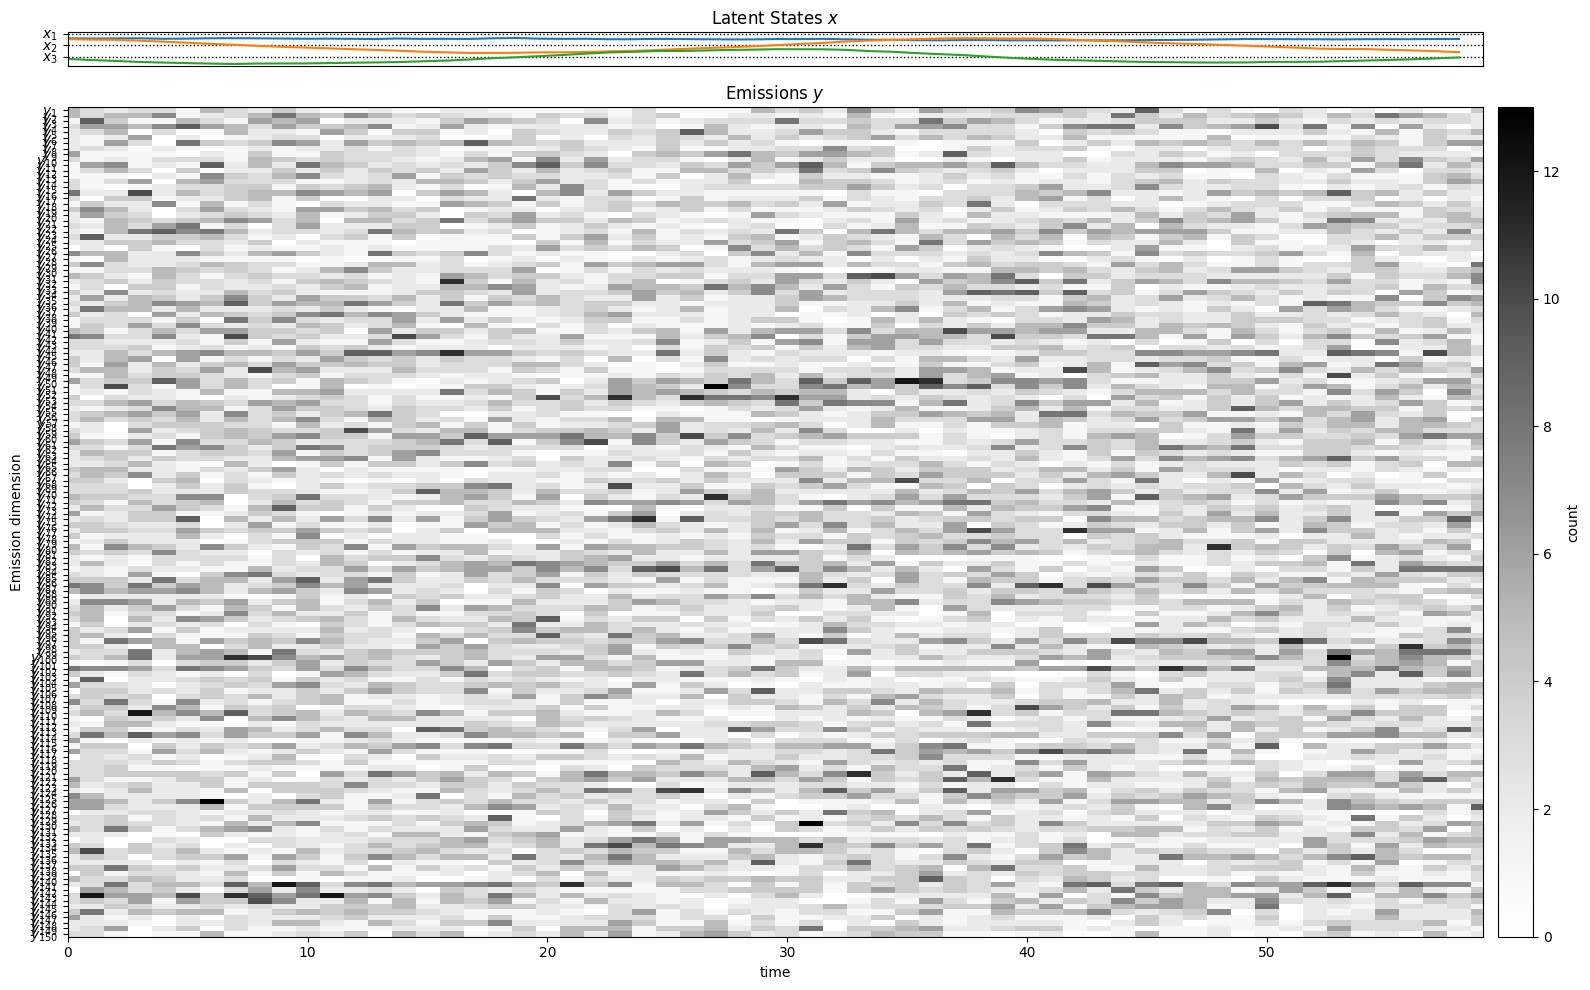

In [192]:
def plot_emissions_poisson(states, data):
    """
    Plot the emissions of a Poisson :DS
    """
    latent_dim = states.shape[-1]
    emissions_dim = data.shape[-1]
    num_timesteps = data.shape[0]

    fig, axs = plt.subplots(2, 2, 
                            height_ratios=(2, emissions_dim / latent_dim), 
                            width_ratios=(40,1), figsize=(16, 10))
    
    # Plot the continuous latent states
    lim = 1.5 * abs(states).max()
    for d in range(latent_dim):
        axs[0,0].axhline(-lim * d, color='k', ls=':', lw=1)
        axs[0,0].plot(states[:, d] - lim * d, "-")
    axs[0,0].set_yticks(-jnp.arange(latent_dim) * lim)
    axs[0,0].set_yticklabels(["$x_{}$".format(d + 1) for d in range(latent_dim)])
    axs[0,0].set_xticks([])
    axs[0,0].set_xlim(0, num_timesteps)
    axs[0,0].set_title(r"Latent States $x$")

    axs[0,1].set_visible(False)

    lim = abs(data).max()
    im = axs[1,0].imshow(data.T, aspect="auto", interpolation="none", cmap="Greys")
    axs[1,0].set_xlabel("time")
    axs[1,0].set_xlim(0, num_timesteps - 1)
    axs[1,0].set_yticks(jnp.arange(emissions_dim))
    axs[1,0].set_yticklabels([rf"$y_{{ {i+1}}}$" for i in jnp.arange(emissions_dim)])
    axs[1,0].set_ylabel("Emission dimension")
    axs[1,0].set_title(r"Emissions $y$")
    plt.colorbar(im, cax=axs[1,1], label="count")

    plt.tight_layout()
    
plot_emissions_poisson(all_states[0], all_emissions[0])

In [187]:
posts = vmap(lambda emissions: cmgs(params, EKFIntegrals(), emissions))(all_emissions)

Text(0.5, 1.0, 'true and inferred states using CMGS')

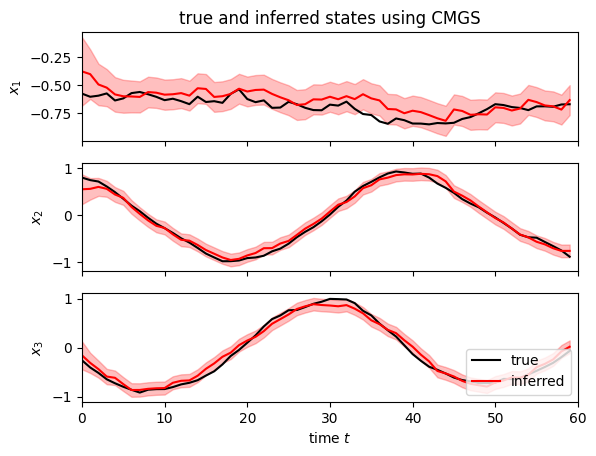

In [189]:
i = 0
fig, axs = plt.subplots(3, 1, sharex=True)
lim = 1.5 * abs(all_states[i]).max()
for d in range(3):
    axs[d].plot(all_states[i, :, d], "-k", label="true")
    axs[d].plot(posts.filtered_means[i, :, d], "-r", label="inferred")
    axs[d].fill_between(
        jnp.arange(num_timesteps),
        posts.filtered_means[i, :, d] - 2 * jnp.sqrt(posts.filtered_covariances[i, :, d, d]),
        posts.filtered_means[i, :, d] + 2 * jnp.sqrt(posts.filtered_covariances[i, :, d, d]),
        color="r",
        alpha=0.25,
    )
    axs[d].set_ylabel(rf"$x_{d+1}$")

axs[-1].set_xlabel(r"time $t$")    
axs[-1].legend(loc="lower right")
axs[-1].set_xlim(0, num_timesteps)
axs[0].set_title("true and inferred states using CMGS")

In [190]:
posts.marginal_loglik

Array([-17319.182, -17226.594, -17173.42 , -17486.662, -17261.234,
       -17483.398, -17293.01 , -17307.814, -17425.549, -17245.213,
       -17474.639, -17370.062, -17300.168, -17385.705, -17292.086,
       -17571.143, -17512.328, -17180.78 , -17245.494, -17247.652,
       -17450.25 , -17180.158, -17451.783, -17125.701, -17451.006,
       -17516.885, -17616.574, -17336.998, -17360.068, -17354.807,
       -17188.479, -17350.695, -17387.852, -17266.92 , -17145.986,
       -17127.73 , -17349.338, -17327.92 , -17435.914, -17467.154,
       -17234.533, -17339.543, -17517.65 , -17222.836, -17217.887,
       -17252.498, -17276.172, -17542.113, -17567.598, -17344.152,
       -17123.29 , -17392.938, -17305.354, -17130.31 , -17267.209,
       -17321.71 ], dtype=float32)

In [ ]:
posts.

In [193]:
fbgd_key = jr.PRNGKey(0)
fbgd_params, fbgd_losses = model.fit_sgd(init_params, 
                                       props, 
                                       batch_emissions, 
                                       optimizer=optax.sgd(learning_rate=0.025, momentum=0.95),
                                       batch_size=num_batches, 
                                       num_epochs=500, 
                                       key=fbgd_key)

AttributeError: 'GeneralizedGaussianSSM' object has no attribute 'initialize'

In [194]:
params

ParamsGGSSM(initial_mean=Array([0., 0., 0.], dtype=float32), initial_covariance=Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), dynamics_function=<function <lambda> at 0x7f94a13b8900>, dynamics_covariance=Array([[0.001, 0.   , 0.   ],
       [0.   , 0.001, 0.   ],
       [0.   , 0.   , 0.001]], dtype=float32), emission_mean_function=<function <lambda> at 0x7f94a133ae80>, emission_cov_function=<function <lambda> at 0x7f94a133afc0>, emission_dist=<function <lambda> at 0x7f94a13b89a0>)